# Классика 

In [328]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA


In [398]:
train = pd.read_csv("train.csv")
# train = train.replace([np.inf, -np.inf], np.nan)
# train = train.dropna(1)
train = train.to_numpy()
train = train[:, 1:]
labels = train[:, -1].astype('int')
train = train[:, :-1].astype('float')
train_max = np.where(np.logical_or(train != train, train == np.inf), 0, train).max(axis=0)
train = np.array([np.where(col == np.inf, col_max, col) for col, col_max in zip(train.T, train_max)])
train = train.T

int_col = []
float_col = []
useful = []
for col in range(train.shape[1]):
    if len(np.unique(train[:, col])) == 1:
        continue
    useful.append(col)
#     # if len(np.unique(train[:, col])) < 10
#     if np.array([val.is_integer() for val in train[:, col]]).all() and train[:, col].min() == 0 and len(np.unique(train[:, col])) == train[:, col].max() + 1:
#         int_col.append(col)
#     else:
#         float_col.append(col)
# train_int = train[:, int_col]
# train_float = train[:, float_col]

# ohe = OneHotEncoder()
# train_int = ohe.fit_transform(train_int).toarray()

train = train[:, useful]

si = SimpleImputer(missing_values=np.nan, strategy='mean')
train = si.fit_transform(train)
scaler = StandardScaler()
train = scaler.fit_transform(train)

# train = np.concatenatorch==1.6.0+cpute((train_float, train_int), axis=1)
# int_col


In [418]:
test = pd.read_csv("test.csv")
# test = test.replace([np.inf, -np.inf], np.nan)
test = test.to_numpy()
names = test[:, 0]
test = test[:, 1:].astype('float')
test = np.array([np.where(col == np.inf, col_max, col) for col, col_max in zip(test.T, train_max)])
test = test.T

# test_int = test[:, int_col]
# test_float = test[:, float_col]
test = test[:, useful]

# test_int = ohe.transform(test_int).toarray()
test = si.transform(test)
test = scaler.transform(test)

# test = np.concatenate((test_float, test_int), axis=1)



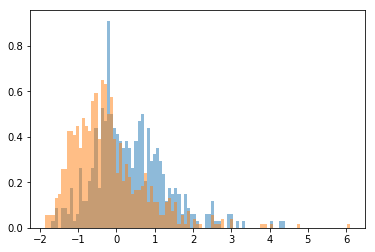

In [284]:
i = 1
feat = train[:, i]
f_max = np.where(feat != feat, 0, feat).max()
f_min = np.where(feat != feat, 0, feat).min()
bins = np.linspace(f_min, f_max, 100)
feat0 = feat[labels == 0]
feat1 = feat[labels == 1]
hist0 = plt.hist(feat0, bins, alpha=0.5, density=True)
hist1 = plt.hist(feat1, bins, alpha=0.5, density=True)
plt.show()


In [45]:
np.unique(labels, return_counts=True)


(array([0.0, 1.0], dtype=object), array([424, 671]))

In [400]:
def get_score(x, y, n_components, C):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    pipe = Pipeline([
        # ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        # ('scaler', StandardScaler()),
        ('feature extractor', PCA(n_components=n_components, whiten=True)),
        ('svc', SVC(gamma='auto', C=C))
    ])
    # pipe = SVC(gamma='auto', C=C)
    pipe.fit(x_train, y_train)
    y_pred = pipe.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.show()
    return roc_auc_score(y_test, y_pred)
    # return 


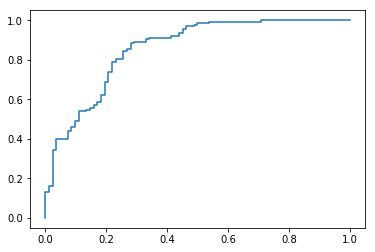

0.8553498308705715

In [401]:
get_score(train, labels, 200, 1)


# Сети

In [407]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


In [408]:
# si = SimpleImputer(missing_values=np.nan, strategy='mean')
# train_ = si.fit_transform(train)
# scaler = StandardScaler()
# train_ = scaler.fit_transform(train_)
# train_ = train
# pca = PCA(n_components=300, whiten=True)
# train_ = pca.fit_transform(train)
x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.2, random_state=42)
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).long()


In [409]:
class TrainDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = TrainDataset(x_train, y_train)

counts = np.bincount(y_train)
weight = np.array([1 / counts[i] for i in y_train])
sampler = WeightedRandomSampler(torch.tensor(weight), len(weight))
dataloader = DataLoader(dataset, batch_size=32, num_workers=4, sampler=sampler)


/home/stan/anaconda3/lib/python3.7/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


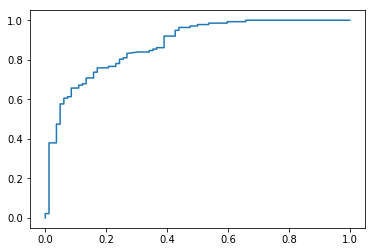

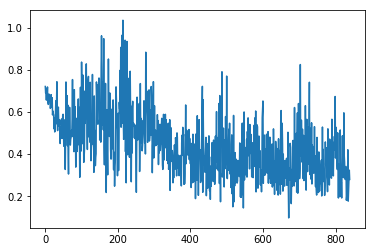

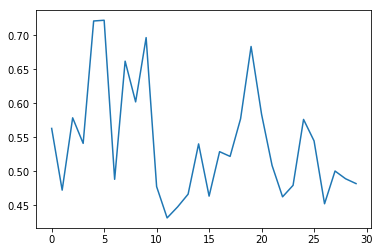

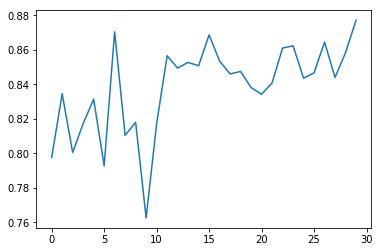

0.8771141178565071

In [449]:
max_epoch = 30

torch.manual_seed(42)
np.random.seed(42)

sm = nn.Softmax(dim=1)

n_hidden = 128
model = nn.Sequential(
    nn.Linear(x_train.shape[1], n_hidden), 
    nn.ReLU(), 
    nn.Linear(n_hidden, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 2)
)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

batch_loss = []
epoch_loss = []
roc_auc = []
for epoch in range(max_epoch):
    for batch in dataloader:
        x, y = batch
        x = x.float()
        y = y.long()
        y_ = model(x)
        l = loss(y_, y)
        l.backward()
        optimizer.step()
        batch_loss.append(l.item())
    y_test_ = model(x_test)
    epoch_loss.append(loss(y_test_, y_test).item())
    roc_auc.append(roc_auc_score(y_test.numpy(), sm(y_test_).detach().numpy()[:, 1]))
    print(f'{epoch}/{max_epoch}\r', end="")
fpr, tpr, _ = roc_curve(y_test.numpy(), y_test_.detach().numpy()[:, 1])
plt.plot(fpr, tpr)
plt.show()
plt.plot(batch_loss)
plt.show()
plt.plot(epoch_loss)
plt.show()
plt.plot(roc_auc)
plt.show()
roc_auc[-1]

In [447]:
val = torch.tensor(test).float()
pred = sm(model(val))[:, 1].detach().numpy()


In [448]:
res = pd.DataFrame(data=np.concatenate((names, pred)).reshape(2,-1).T, columns=['sample_id', 'y'])
res.to_csv('submition.csv', index=False)
